In [278]:
"""
This script provides utility functions for formatted printing of NumPy matrices and saving matrices to CSV files.
"""


# system imports
import os

# third party imports
import numpy as np


def printFormatted(matrix, decimals=4):
    """
    Prints the matrix with formatted elements aligned in columns for improved readability.

    Parameters:
    ----------
    matrix : numpy array
        The matrix to be printed.
    decimals : int, optional (default=4)
        The number of decimal places for formatting the elements.

    Returns:
    -------
    None
        This function does not return any value; it prints the formatted matrix directly to the console.

    Notes:
    -----
    - The function aligns columns based on the maximum width needed for the formatted elements, ensuring the matrix is displayed neatly.
    - This function is useful for visual inspection of numerical matrices, especially those with varying magnitudes.
    
    Example:
    --------
    >>> import numpy as np
    >>> matrix = np.array([[1.234567, 123.456789], [0.0001234, 1.2345]])
    >>> print('Classic print:')
    >>> print(matrix)
    Classic print:
    [[1.2345670e+00 1.2345679e+02]
     [1.2340000e-04 1.2345000e+00]]
     
    >>> print('\nFormatted print:')
    >>> printFormatted(matrix, decimals=4)
         1.2346  123.4568
         0.0001    1.2345
    
    """

    # Determine the maximum width needed to keep alignment
    max_width = max(len(f'{value:.{decimals}f}') for row in matrix for value in row)

    # Create a formatted string for each element in the matrix, ensuring alignment
    formatted_matrix = '\n'.join([' '.join([f'{value:>{max_width}.{decimals}f}' for value in row]) for row in matrix])

    # Print the formatted matrix
    print(formatted_matrix)


def py_test_csv(array):
    """
    Save a numpy array as a CSV file in ./debugCsvPy/py_test.csv

    Parameters:
    array (numpy.ndarray): The input array to be saved as a CSV file.
    Returns:
    None
    """
    
    output_dir = 'debugCsvPy'  # Directory where CSV files will be stored
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    py_dict_path = os.path.join(output_dir, 'py_test.csv')
    np.savetxt(py_dict_path, array, delimiter=',', fmt='%.6f')



In [279]:
"""
This script provides utility functions for generating a Discrete Cosine Transform (DCT) 
orthonormal basis matrix and for testing various properties of matrices such as independence 
of columns, normalization, and coherence.
"""

import numpy as np
import scipy.fftpack as fftpack
import pywt

def dct_dictionary(N):
    """
    Generates a Discrete Cosine Transform (DCT) orthonormal basis matrix.

    The DCT basis is commonly used in signal processing and data compression. 
    It transforms a signal into a sum of cosine functions oscillating at different frequencies. 
    The resulting matrix can be used for orthogonal transformations of signals.
    
    DCT basis is sparifying.
    

    Parameters
    ----------
    N : int
        The size of the dictionary (i.e., the length of the signal).

    Returns
    -------
    dict_matrix : numpy.ndarray
        The generated DCT dictionary matrix of shape (N, N), where each column represents 
        a DCT basis vector.

    Example
    -------
    >>> generate_dct_dictionary(4)
    array([[ 0.5       ,  0.5       ,  0.5       ,  0.5       ],
           [ 0.65328148,  0.27059805, -0.27059805, -0.65328148],
           [ 0.5       , -0.5       , -0.5       ,  0.5       ],
           [ 0.27059805, -0.65328148,  0.65328148, -0.27059805]])
    """
    
    # Generate a DCT basis dictionary
    dict_matrix = fftpack.dct(np.eye(N), norm='ortho')    
    return dict_matrix



## ------------------------------------------------------------------------------------------------
## REST OF THE FUNCTIONS ARE FOR TESTING PURPOSES
## ------------------------------------------------------------------------------------------------



def compute_independent_columns(A, tol=1e-10):
    """
    Computes the independent columns of a matrix using the QR decomposition.

    The function identifies independent columns of a given matrix `A` by performing a QR 
    decomposition. It selects columns corresponding to non-zero diagonal elements of the 
    `R` matrix, which are considered linearly independent.

    Parameters
    ----------
    A : numpy.ndarray
        The matrix for which to compute the independent columns.
    tol : float, optional (default=1e-10)
        The tolerance value for considering diagonal elements of `R` as non-zero.

    Returns
    -------
    ind_cols : numpy.ndarray
        A matrix containing the independent columns of `A`.

    Notes
    -----
    - The QR decomposition is used to determine the rank of the matrix `A`.
    - Columns corresponding to non-zero diagonal elements of the `R` matrix are considered independent.

    Example
    -------
    >>> A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    >>> compute_independent_columns(A)
    array([[1, 2],
           [4, 5],
           [7, 8]])
    """
    # Perform the QR decomposition
    Q, R = np.linalg.qr(A)

    # Find the independent columns based on the rank of R
    rank = np.sum(np.abs(np.diagonal(R)) > tol)
    ind_cols = A[:, :rank]

    return ind_cols

def check_normalization(A):
    """
    Checks if the columns of a matrix are normalized (i.e., each column has a unit norm).

    The function calculates the norm of each column in the matrix `A` and checks if all 
    column norms are close to 1.0, which indicates normalization.

    Parameters
    ----------
    A : numpy.ndarray
        The matrix to check for normalization.

    Returns
    -------
    is_normalized : bool
        True if all columns of `A` are normalized, False otherwise.

    Example
    -------
    >>> A = np.array([[1, 0], [0, 1]])
    >>> check_normalization(A)
    True
    """
    column_norms = np.linalg.norm(A, axis=0)
    is_normalized = np.allclose(column_norms, 1.0)
    return is_normalized


def compute_coherence(matrix):
    """
    Computes the coherence of the given matrix.

    Coherence is a measure of the maximum correlation between any two columns of a matrix. 
    It is useful in various applications, such as signal processing and compressed sensing, 
    to assess the degree of similarity between different columns of the matrix.

    Parameters
    ----------
    matrix : numpy.ndarray
        An N x M matrix where coherence is to be calculated.

    Returns
    -------
    coherence : float
        The coherence of the matrix, defined as the maximum absolute value of the off-diagonal 
        elements in the Gram matrix of the column-normalized input matrix.

    Example
    -------
    >>> matrix = np.array([[1, 0], [0, 1]])
    >>> compute_coherence(matrix)
    0.0
    """
    # Normalize the columns of the matrix
    normalized_matrix = matrix / np.linalg.norm(matrix, axis=0, keepdims=True)
    
    # Compute the Gram matrix (inner products between all pairs of columns)
    gram_matrix = np.dot(normalized_matrix.T, normalized_matrix)
    
    # Remove the diagonal elements (which are all 1's) to only consider distinct columns
    np.fill_diagonal(gram_matrix, 0)
    
    # Compute the coherence as the maximum absolute value of the off-diagonal elements
    coherence = np.max(np.abs(gram_matrix))
    
    return coherence


def check_matrix_properties(A):
    """
    Checks various properties of a matrix.

    The function checks if the matrix `A` is full rank, if its columns and rows are normalized,
    and computes the coherence of the matrix. It also prints the results.

    Parameters
    ----------
    A : numpy.ndarray
        The matrix to check.

    Returns
    -------
    None

    Example
    -------
    >>> A = np.array([[1, 2], [3, 4]])
    >>> check_matrix_properties(A)
    """
    # Check if the matrix is full rank
    is_full_rank = np.linalg.matrix_rank(A) == min(A.shape)

    # Check if the columns are normalized
    is_columns_normalized = check_normalization(A)

    # Check if the rows are normalized
    is_rows_normalized = check_normalization(A.T)

    # Compute the coherence of the matrix
    coherence = compute_coherence(A)

    # Print the results
    print("Is full rank:", is_full_rank)
    print("Are columns normalized:", is_columns_normalized)
    print("Are rows normalized:", is_rows_normalized)
    print("Coherence:", coherence)


In [280]:
"""
SL0 Algorithm Implementation

This file contains an implementation of the Smoothed L0 (SL0) algorithm for sparse signal recovery.
"""

import numpy as np

def SL0(y, A, sigma_min, sigma_decrease_factor=0.5, mu_0=2, L=3, A_pinv=None, showProgress=False):
    """
    Returns the sparsest vector `s` that satisfies the underdetermined system of 
    linear equations `A @ s = y`, using the Smoothed L0 (SL0) algorithm.

    Requires:
    --------
    - numpy as np
    

    Parameters:
    ----------
    y : numpy array
        The observed vector (Mx1), where M is the number of rows in `A`.
    
    A : numpy array
        The measurement matrix (MxN), which should be 'wide', meaning it has more 
        columns than rows (N > M). The number of rows in `A` must match the length 
        of `y`.
    
    sigma_min : float
        The minimum value of `sigma`, which determines the stopping criterion for 
        the algorithm. It should be chosen based on the noise level or desired 
        accuracy.
    
    sigma_decrease_factor : float, optional (default=0.5)
        The factor by which `sigma` is decreased in each iteration. This should be 
        a positive value less than 1. Smaller values lead to quicker reduction of 
        `sigma`, possibly at the cost of accuracy for less sparse signals.
    
    mu_0 : float, optional (default=2)
        The scaling factor for `mu`, where `mu = mu_0 * sigma^2`. This parameter 
        influences the convergence rate of the algorithm.
    
    L : int, optional (default=3)
        The number of iterations for the inner loop (steepest descent). Increasing 
        `L` can improve the precision of the result but also increases computational 
        cost.
    
    A_pinv : numpy array, optional
        The precomputed pseudoinverse of the matrix `A`. If not provided, it will be 
        calculated within the function as `np.linalg.pinv(A)`. Providing this value 
        is beneficial if the function is called repeatedly with the same `A`.
    
    showProgress : bool, optional (default=False)
        If `True`, the function prints the current value of `sigma` during each 
        iteration, which helps monitor the convergence process.

    Returns:
    -------
    s : numpy array
        The estimated sparse signal (Nx1) that best satisfies the equation `A @ s = y`.

    Notes:
    -----
    - The algorithm works by iteratively reducing `sigma` in a geometric sequence, 
      starting with `sigma = 2 * max(abs(s))` and ending with `sigma_min`. At each 
      step, the function adjusts `s` to minimize the L0-norm by smoothing it using 
      a Gaussian kernel.
    
    - The choice of `sigma_min` is crucial: for noiseless cases, a smaller `sigma_min` 
      yields a sparser solution; for noisy cases, `sigma_min` should be a few times 
      the standard deviation of the noise in `s`.

    - If `A_pinv` is precomputed and passed as an argument, the function becomes 
      more efficient, especially in scenarios where it is called repeatedly with the 
      same `A`.

      
      References:
      ----------
    - Original authors (MATLAB): Massoud Babaie-Zadeh, Hossein Mohimani, 4 August 2008.
    - Web-page: http://ee.sharif.ir/~SLzero

    - Ported to python: RosNaviGator https://github.com/RosNaviGator, 2024

   """

    if A_pinv is None:
        A_pinv = np.linalg.pinv(A)
        
    # Initialize the variables
    s = A_pinv @ y
    sigma = 2 * max(np.abs(s))

    # Define lambda function for delta
    OurDelta = lambda s, sigma: s * np.exp(-s**2 / sigma**2)
 
    # Main loop
    while sigma > sigma_min:
        for i in range(L):
            delta = OurDelta(s, sigma)
            s = s - mu_0 * delta
            s = s - A_pinv @ (A @ s - y)
        
        if showProgress:
            print(f'sigma: {sigma}')

        sigma = sigma * sigma_decrease_factor

    return s


In [281]:
"""
This script provides functions to calculate the Signal-to-Noise Ratio (SNR) between 
an original and a reconstructed signal, and to plot these signals together, displaying 
the SNR. It also includes functionality to save the plotted signals to a specified directory.
"""



import matplotlib.pyplot as plt
import numpy as np
import os

def calculate_snr(signal, recovered_signal):
    """
    Calculates the Signal-to-Noise Ratio (SNR) between the original signal and the recovered signal.

    Parameters
    ----------
    signal : numpy.ndarray
        The original signal.
    recovered_signal : numpy.ndarray
        The recovered signal after some processing or recovery algorithm.

    Returns
    -------
    snr : float
        The Signal-to-Noise Ratio (SNR) in decibels (dB).

    Notes
    -----
    - The SNR is calculated as 20 * log10(norm(original_signal) / norm(original_signal - recovered_signal)).
    - A higher SNR value indicates a better recovery, with less error relative to the original signal.
    """
    error = recovered_signal - signal
    snr = 20 * np.log10(np.linalg.norm(signal) / np.linalg.norm(error))
    
    return snr



def plot_signals(original_signal, reconstructed_signal, snr=None, original_name="Original Signal", 
                 reconstructed_name="Reconstructed Signal", save_path=None, filename=None,
                 start_pct=0.0, num_samples=None):
    """
    Plots a section of the original signal and the reconstructed signal on the same plot with the given names,
    displays the Signal-to-Noise Ratio (SNR) in a text box, and saves the plot to a specified directory.

    Parameters
    ----------
    original_signal : numpy.ndarray
        The original signal to be plotted.
    
    reconstructed_signal : numpy.ndarray
        The reconstructed signal to be plotted.
    
    original_name : str, optional (default="Original Signal")
        The name to display for the original signal in the plot.
    
    reconstructed_name : str, optional (default="Reconstructed Signal")
        The name to display for the reconstructed signal in the plot.
    
    save_path : str, optional
        The directory path where the plot should be saved. If None, the plot will not be saved.
    
    filename : str, optional
        The name of the file to save the plot as. If None and save_path is provided, a default name will be generated.
    
    snr : float, optional (default=None)
        The Signal-to-Noise Ratio to display. If None, it will be computed using the original and reconstructed signals.
    
    start_pct : float, optional (default=0.0)
        The percentage (between 0 and 1) of the way through the signal to start plotting. For example, 0.5 means start 
        from the halfway point of the signals.
    
    num_samples : int, optional (default=None)
        The number of samples to plot from the start point. If None, it will plot to the end of the signals.
    """
    
    # Ensure the signals have the same length
    if len(original_signal) != len(reconstructed_signal):
        raise ValueError("The original signal and the reconstructed signal must have the same length.")
    
    # Calculate the start index based on percentage
    start_idx = int(start_pct * len(original_signal))
    
    # Determine the end index based on num_samples
    if num_samples is not None:
        end_idx = start_idx + num_samples
    else:
        end_idx = len(original_signal)
    
    # Check if the end index exceeds the signal length
    if end_idx > len(original_signal):
        raise ValueError(f"You tried to plot from sample {start_idx} to sample {end_idx}, "
                         f"but the signal only has {len(original_signal)} samples!")
    
    # Slice the signals to the selected section
    original_signal_section = original_signal[start_idx:end_idx]
    reconstructed_signal_section = reconstructed_signal[start_idx:end_idx]
    
    # Calculate SNR if not provided
    if snr is None:
        snr = calculate_snr(original_signal_section, reconstructed_signal_section)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(original_signal_section, label=original_name, color='blue', linewidth=1.5)
    plt.plot(reconstructed_signal_section, label=reconstructed_name, color='red', linestyle='--', linewidth=1.5)
    
    # Title and labels
    plt.title(f"{original_name} vs {reconstructed_name} (Section: {start_pct*100:.1f}% - {num_samples} samples)")
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    
    # Add a legend
    plt.legend()
    
    # Display SNR in a text box
    plt.text(0.05, 0.95, f'SNR: {snr:.2f} dB', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Grid and show plot
    plt.grid(True)
    
    # Save the plot if a save path is provided
    if save_path is not None:
        # Ensure the save directory exists
        os.makedirs(save_path, exist_ok=True)
        
        # Use provided filename or generate a default one
        if filename is None:
            filename = f"{original_name}_vs_{reconstructed_name}_section.png"
        
        # Define the file path to save the plot
        file_path = os.path.join(save_path, filename)
        plt.savefig(file_path)
        print(f"Plot saved to {file_path}")
    
    # Display the plot
    plt.show()



In [282]:
"""
Orthogonal Matching Pursuit (OMP) algorithm for sparse coding.
"""

import numpy as np


def OMP(dictio, sig, max_coeff):
    """
    Orthogonal Matching Pursuit (OMP) algorithm for sparse coding.

    This function implements the OMP algorithm, which is used to find the sparse
    representation of a signal over a given dictionary.
    
    Parameters
    ----------
    dictio : numpy.ndarray
        The dictionary to use for sparse coding. It should be a matrix of size (n x K), 
        where n is the signal dimension and K is the number of atoms in the dictionary.
        (its columns MUST be normalized).
    
    sig : numpy.ndarray
        The signals to represent using the dictionary. 
        It should be a matrix of size (n x N), where N is the number of signals.
    
    max_coeff : int
        The maximum number of coefficients to use for representing each signal.
    
    Returns
    -------
    s : numpy.ndarray
        The sparse representation of the signals over the dictionary.
        It should be a matrix of size (K x N).
    """

    [n, p] = sig.shape
    [_, key] = dictio.shape
    s = np.zeros((key, p))
    for k in range(p):
        x = sig[:, k]
        residual = x.copy()
        indx = np.array([], dtype=int)
        current_atoms = np.empty((n, 0))
        norm_x = np.linalg.norm(x)
        for j in range(max_coeff):
            proj = dictio.T @ residual
            pos = np.argmax(np.abs(proj))
            indx = np.append(indx, pos)
            # Update selected atoms matrix
            current_atoms = np.column_stack((current_atoms, dictio[:, pos]))
            # Solve least squares problem using QR decomposition for stability
            q, r = np.linalg.qr(current_atoms)
            a = np.linalg.solve(r, q.T @ x)
            residual = x - current_atoms @ a
            # Break if norm of residual is suff small (relative to original signal)
            if np.linalg.norm(residual) < 1e-6 * norm_x:
                break
        temp = np.zeros((key,))
        temp[indx] = a
        s[:, k] = temp

    return s


In [283]:
"""
MOD (Method of Optimal Directions) algorithm for dictionary learning with improved numerical stability.
"""

# system imports
import os

# third party imports
import numpy as np
import scipy.sparse as sp
from scipy.linalg import solve



def I_findDistanceBetweenDictionaries(original, new):
    """
    Calculates the distance between two dictionaries.

    Parameters:
    ----------
    original : numpy.ndarray
        The original dictionary.

    new : numpy.ndarray
        The new dictionary.

    Returns:
    -------
    catchCounter : int
        The number of elements that satisfy the condition errorOfElement < 0.01.
    totalDistances : float
        The sum of all errorOfElement values.
    
    
    """

    # first: all the columns in the original start with positive values
    catchCounter = 0
    totalDistances = 0

    for i in range(new.shape[1]):
        new[:,i] = np.sign(new[0,i]) * new[:,i]

    for i in range(original.shape[1]):
        d = np.sign(original[0,i]) * original[:,i]
        distances = np.sum(new - np.tile(d, (1, new.shape[1])), axis=0)
        index = np.argmin(distances)
        errorOfElement = 1 - np.abs(new[:,index].T @ d)
        totalDistances += errorOfElement
        catchCounter += errorOfElement < 0.01

    ratio = catchCounter / original.shape[1]
    return ratio, totalDistances





def MOD(data, parameters):
    """
    Method of Optimal Directions (MOD) algorithm for dictionary learning .

    The MOD algorithm is a method for learning a dictionary for sparse representation of signals.
    It iteratively updates the dictionary to best represent the input data with sparse coefficients
    using the Orthogonal Matching Pursuit (OMP) algorithm.

    Parameters
    ----------
    data : numpy.ndarray
        An (n x N) matrix containing N signals, each of dimension n.
    
    parameters : dict
        A dictionary containing the parameters for the MOD algorithm:
            - K : int
                The number of dictionary elements (columns) to train.
            
            - num_iterations : int
                The number of iterations to perform for dictionary learning.
            
            - initialization_method : str
                Method to initialize the dictionary. Options are:
                * 'DataElements' - Initializes the dictionary using the first K data signals.
                * 'GivenMatrix' - Initializes the dictionary using a provided matrix 
                  (requires 'initial_dictionary' key).

            - initial_dictionary : numpy.ndarray, optional
                The initial dictionary matrix to use if 'initialization_method' is 
                set to 'GivenMatrix'. It should be of size (n x K).

            - L : int
                The number of non-zero coefficients to use in OMP for sparse
                representation of each signal.

    Returns
    -------
    dictionary : numpy.ndarray
        The trained dictionary of size (n x K), where each column is a dictionary element.

    coef_matrix : numpy.ndarray
        The coefficient matrix of size (K x N), representing the sparse representation
        of the input data using the trained dictionary.
    """

    # Check if the number of signals is smaller than the dictionary size
    if data.shape[1] < parameters['K']:
        print("MOD: number of training signals is smaller than the dictionary size. Returning trivial solution...")
        dictionary = data[:, :data.shape[1]]
        coef_matrix = np.eye(data.shape[1])  # Trivial coefficients
        return dictionary, coef_matrix

    # Initialize dictionary based on the specified method
    if parameters['initialization_method'] == 'DataElements':
        dictionary = data[:, :parameters['K']]
    elif parameters['initialization_method'] == 'GivenMatrix':
        if 'initial_dictionary' not in parameters:
            raise ValueError("initial_dictionary parameter is required when "
                             "initialization_method is set to 'GivenMatrix'.")
        dictionary = parameters['initial_dictionary']
    else:
        raise ValueError(
            "Invalid value for initialization_method. Choose 'DataElements' or 'GivenMatrix'.")

    # Convert to float64 for precision
    dictionary = dictionary.astype(np.float64)

    # Normalize dictionary columns and avoid division by zero
    column_norms = np.linalg.norm(dictionary, axis=0)
    column_norms[column_norms < 1e-10] = 1  # Prevent division by zero
    dictionary /= column_norms

    # Ensure positive first elements
    dictionary *= np.sign(dictionary[0, :])

    prev_dictionary = dictionary.copy()

    # Run MOD algorithm
    for iter_num in range(parameters['num_iterations']):
        # Step 1: Sparse coding using OMP
        coef_matrix = OMP(dictionary, data, parameters['L'])

        # Step 2: Update the dictionary
        regularization_term = 1e-7 * sp.eye(coef_matrix.shape[0])
        matrix_a = coef_matrix @ coef_matrix.T + regularization_term.toarray()

        # Use solve instead of np.linalg.inv for better numerical stability
        dictionary = data @ coef_matrix.T @ solve(
            matrix_a, np.eye(matrix_a.shape[0]), assume_a='pos')

        # Normalize dictionary columns and avoid division by zero
        column_norms = np.linalg.norm(dictionary, axis=0)
        column_norms[column_norms < 1e-10] = 1  # Prevent division by zero
        dictionary /= column_norms

        # Ensure positive first elements
        dictionary *= np.sign(dictionary[0, :])

        # Convergence check
        if np.linalg.norm(dictionary - prev_dictionary) < 1e-5:
            print(f"MOD converged after {iter_num + 1} iterations.")
            break

        prev_dictionary = dictionary.copy()

    return dictionary, coef_matrix


In [284]:
"""
K-SVD algorithm for dictionary learning and sparse coding using Orthogonal Matching Pursuit (OMP).
Includes functions for updating dictionary elements, handling singular value decomposition (SVD)
for vectors, and clearing redundant dictionary elements.
"""

import numpy as np
from scipy.sparse.linalg import svds


def svds_vector(v):
    """
    Handle SVD for a vector or a 2D matrix with one dimension equal to 1.
    """
    v = np.asarray(v)
    
    if v.ndim == 1:
        v = v.reshape(-1, 1)
    elif v.ndim == 2 and (v.shape[0] == 1 or v.shape[1] == 1):
        pass
    else:
        raise ValueError("Input must be a vector or a 2D array with one dimension equal to 1.")
    
    s = np.linalg.norm(v)
    if s > 0:
        u = v / s
    else:
        u = np.zeros_like(v)
    
    vt = np.array([[1]])

    return u, s, vt

def I_findBetterDictionaryElement(data, dictionary, j, coeff_matrix, numCoefUsed=1):
    """
    Update the j-th dictionary element.
    """
    relevantDataIndices = np.nonzero(coeff_matrix[j, :])[0]
    if relevantDataIndices.size == 0:
        errorMat = data - dictionary @ coeff_matrix
        errorNormVec = np.sum(errorMat ** 2, axis=0)
        i = np.argmax(errorNormVec)
        betterDictionaryElement = data[:, i] / np.linalg.norm(data[:, i])
        betterDictionaryElement *= np.sign(betterDictionaryElement[0])
        coeff_matrix[j, :] = 0
        newVectAdded = 1
        return betterDictionaryElement, coeff_matrix, newVectAdded
    
    newVectAdded = 0
    tmpCoefMatrix = coeff_matrix[:, relevantDataIndices]
    tmpCoefMatrix[j, :] = 0
    errors = data[:, relevantDataIndices] - dictionary @ tmpCoefMatrix

    if np.min(errors.shape) <= 1:
        u, s, vt = svds_vector(errors)
        betterDictionaryElement = u
        singularValue = s
        betaVector = vt
    else:
        u, s, vt = svds(errors, k=1)
        betterDictionaryElement = u[:, 0]
        singularValue = s[0]
        betaVector = vt[0, :]

    coeff_matrix[j, relevantDataIndices] = singularValue * betaVector.T

    return betterDictionaryElement, coeff_matrix, newVectAdded

def I_clearDictionary(dictionary, coeff_matrix, data):
    """
    Clear or replace redundant dictionary elements.
    """
    T2 = 0.99
    T1 = 3
    K = dictionary.shape[1]
    Er = np.sum((data - dictionary @ coeff_matrix) ** 2, axis=0)
    G = dictionary.T @ dictionary
    G -= np.diag(np.diag(G))
    for jj in range(K):
        if np.max(G[jj, :]) > T2 or np.count_nonzero(np.abs(coeff_matrix[jj, :]) > 1e-7) <= T1:
            pos = np.argmax(Er)
            Er[pos] = 0
            dictionary[:, jj] = data[:, pos] / np.linalg.norm(data[:, pos])
            G = dictionary.T @ dictionary
            G -= np.diag(np.diag(G))
    return dictionary

def KSVD(data, param):
    """
    K-SVD algorithm for dictionary learning.
    """
    if param['preserve_dc_atom'] > 0:
        fixedDictElem = np.zeros((data.shape[0], 1))  
        fixedDictElem[:data.shape[0], 0] = 1 / np.sqrt(data.shape[0])
    else:
        fixedDictElem = np.empty((0, 0))

    if data.shape[1] < param['K']:
        print('KSVD: number of training data is smaller than the dictionary size. Trivial solution...')
        dictionary = data[:, :data.shape[1]]
        coef_matrix = np.eye(data.shape[1])
        return dictionary, coef_matrix
    
    dictionary = np.zeros((data.shape[0], param['K']), dtype=np.float64)    
    if param['initialization_method'] == 'DataElements':
        dictionary[:, :param['K'] - param['preserve_dc_atom']] = \
            data[:, :param['K'] - param['preserve_dc_atom']]
    elif param['initialization_method'] == 'GivenMatrix':
        dictionary[:, :param['K'] - param['preserve_dc_atom']] = \
            param['initial_dictionary'][:, :param['K'] - param['preserve_dc_atom']]

    if param['preserve_dc_atom']:
        tmpMat = np.linalg.lstsq(dictionary + 1e-7 * np.eye(dictionary.shape[1]), fixedDictElem, rcond=None)[0]
        dictionary -= fixedDictElem @ tmpMat

    column_norms = np.sqrt(np.sum(dictionary ** 2, axis=0))
    column_norms[column_norms < 1e-10] = 1
    dictionary /= column_norms
    dictionary *= np.sign(dictionary[0, :])

    for iterNum in range(param['num_iterations']):
        coef_matrix = OMP(
            np.hstack((fixedDictElem, dictionary)) if fixedDictElem.size > 0 else dictionary,
            data,
            param['L']
        )
        
        rand_perm = np.random.permutation(dictionary.shape[1])
        for j in rand_perm:
            betterDictElem, coef_matrix, newVectAdded = I_findBetterDictionaryElement(
                data,
                np.hstack((fixedDictElem, dictionary)) if fixedDictElem.size > 0 else dictionary,
                j + fixedDictElem.shape[1],
                coef_matrix,
                param['L']
            )

            dictionary[:, j] = betterDictElem.ravel()
            if param['preserve_dc_atom']:
                tmpCoeff = np.linalg.lstsq(betterDictElem + 1e-7, fixedDictElem, rcond=None)[0]
                dictionary[:, j] -= fixedDictElem @ tmpCoeff
                dictionary[:, j] /= np.linalg.norm(dictionary[:, j])

        dictionary = I_clearDictionary(dictionary, coef_matrix[fixedDictElem.shape[1]:, :], data)

    dictionary = np.hstack((fixedDictElem, dictionary)) if fixedDictElem.size > 0 else dictionary
    
    return dictionary, coef_matrix


In [285]:
import numpy as np

def generate_DBBD_matrix(M, N):
    """
    Generates a deterministic Diagonally Blocked Block Diagonal (DBBD) matrix.

    A DBBD matrix is a type of block diagonal matrix where each block is a square diagonal matrix.

    Parameters
    ----------
    M : int
        Number of rows in the matrix.
    N : int
        Number of columns in the matrix. Should be a multiple of M.

    Returns
    -------
    A : numpy.ndarray
        The generated DBBD matrix of shape (M, N).

    Raises
    ------
    ValueError
        If `N` is not a multiple of `M`.

    Example
    -------
    >>> generate_DBDD_matrix(3, 9)
    array([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 1., 1., 1., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 1., 1., 1.]])
    """


    if N % M != 0:
        raise ValueError("N should be a multiple of M.")
    
    Phi = np.zeros((M, N))
    m = N // M
    
    for i in range(M):
        Phi[i, i*m:(i+1)*m] = 1

    return Phi


def generate_random_matrix(M, N, matrix_type='gaussian'):
    """
    Generates a random matrix based on the specified type.

    Parameters
    ----------
    M : int
        Number of rows in the matrix.
    N : int
        Number of columns in the matrix.
    matrix_type : str, optional (default='gaussian')
        The type of random matrix to generate. Options are:
        - 'gaussian': A matrix with entries drawn from a normal distribution scaled by 1/M.
        - 'scaled_binary': A matrix with binary entries (±0.5), scaled by 1/sqrt(M).
        - 'unscaled_binary': A matrix with binary entries (±1), with no scaling.

    Returns
    -------
    A : numpy.ndarray
        The generated random matrix of shape (M, N).

    Raises
    ------
    ValueError
        If `matrix_type` is not one of the supported types.

    Example
    -------
    >>> generate_random_matrix(2, 3, matrix_type='gaussian')
    array([[ 0.01, -0.02,  0.03],
           [-0.04,  0.05, -0.06]])

    >>> generate_random_matrix(2, 3, matrix_type='scaled_binary')
    array([[-0.5,  0. , -0.5],
           [ 0.5, -0.5,  0. ]])
    
    >>> generate_random_matrix(2, 3, matrix_type='unscaled_binary')
    array([[ 1., -1.,  1.],
           [-1.,  1., -1.]])
    """
    if matrix_type == 'gaussian':
        A = ((1/M)**2) * np.random.randn(M, N)

    elif matrix_type == 'scaled_binary':
        A = np.random.binomial(1, 0.5, size=(M, N)) - 0.5
        A = (1/np.sqrt(M)) * A

    elif matrix_type == 'unscaled_binary':
        A = np.random.binomial(1, 0.5, size=(M, N)) * 2 - 1

    else:
        raise ValueError("Unsupported matrix type. Choose either 'gaussian', 'scaled_binary', or 'unscaled_binary'.")

    return A

# HIGHER LEVEL

In [286]:
import warnings
import numpy as np

class compressedSensing:
    def __init__(self, signal, BLOCK_LEN, CR, matrix_type='gaussian'):
        """
        Constructor for the compressedSensing class.
        
        Parameters:
        -----------
        signal : numpy.ndarray
            The input signal.
        BLOCK_LEN : int
            The number of rows in the measurement matrix Phi.
        CR : int
            Compression ratio (controls the number of rows in Phi).
        matrix_type : str
            Type of the matrix to generate ('gaussian', 'DBBD', etc.).
        """
        self.signal = signal
        self.BLOCK_LEN = BLOCK_LEN
        self.CR = CR
        self.COMP_LEN = BLOCK_LEN // CR  # Compression length (number of rows in Phi)
        
        # Generate measurement matrix Phi based on the specified type
        if matrix_type == 'DBBD':
            self.Phi = generate_DBBD_matrix(self.COMP_LEN, self.BLOCK_LEN)
        else:
            self.Phi = generate_random_matrix(self.COMP_LEN, self.BLOCK_LEN, matrix_type=matrix_type)
        
        # Initialize attributes
        self.training_set = None
        self.test_set = None
        self.training_matrix = None
        self.reconstructed_signal = None
        self.Y = None  # Compressed test signal
        self.theta = None
        self.theta_pinv = None
        self.dictionary = None

    def divide_signal(self, training_percentage):
        """
        Divides the signal into a training set and a test set based on the given percentage.
        
        Parameters:
        -----------
        training_percentage : float
            The percentage of the signal to use for the training set (between 0 and 1).
        """
        training_size = int(training_percentage * len(self.signal))
        
        # Warning if the training set is longer than 1 hour (360 samples/min * 60 min)
        if training_size > 360 * 60:
            warnings.warn("The training set is longer than 1 hour (360 samples/min * 60 min). "
                        "This warning is based on the MIT-BIH Arrhythmia Database, "
                        "and may not apply to other datasets.")
        
        # Warning if using more than 10% of the signal for training
        if training_percentage > 0.1:
            warnings.warn("Using more than 10% of the signal for training may not make sense.")
        
        # Define the training and test sets
        self.training_set = self.signal[:training_size]
        self.test_set = self.signal[training_size:]

        # Ensure the test set size is a multiple of BLOCK_LEN by truncating the test set
        test_size = len(self.test_set)
        test_size_multiple = (test_size // self.BLOCK_LEN) * self.BLOCK_LEN
        self.test_set = self.test_set[:test_size_multiple]

        # Ensure the training set size is a multiple of BLOCK_LEN
        num_cols = training_size // self.BLOCK_LEN
        if num_cols < self.BLOCK_LEN:
            warnings.warn("The number of samples (columns) in the training matrix is shorter than "
                        "the number of rows, which can cause issues with dictionary learning.")

        # Reshape the training set using Fortran-style ordering ('F')
        self.training_matrix = self.training_set[:num_cols * self.BLOCK_LEN].reshape(self.BLOCK_LEN, num_cols, order='F')


    def compress_test_set(self):
        """
        Compresses the test set using the measurement matrix Phi.
        """
        if self.test_set is None:
            raise ValueError("Test set not defined. Please divide the signal before compressing.")

        M, N = self.Phi.shape
        SIGNAL_BLOCKS = len(self.test_set) // N
        self.Y = np.zeros((M, SIGNAL_BLOCKS))

        # Sampling phase: Compress signal block-wise
        for i in range(SIGNAL_BLOCKS):
            self.Y[:, i] = self.Phi @ self.test_set[i * N: (i + 1) * N]

    def generate_dictionary(self, dictionary_type='dct'):
        """
        Generates the dictionary based on the specified type.
        
        Parameters:
        -----------
        dictionary_type : str
            The type of dictionary to generate ('dct', etc.).
        """
        if dictionary_type == 'dct':
            self.dictionary = dct_dictionary(self.BLOCK_LEN)
        else:
            raise ValueError("Unsupported dictionary type.")
        
    def recover_signal(self, sigma_min=1e-4, sigma_decrease_factor=0.5, mu_0=2, L=3, showProgress=False):
        """
        Recovers the original signal using the SL0 algorithm, after compressing.
        
        Parameters are the same as the SL0 function.
        """
        if self.Y is None:
            raise ValueError("Test set has not been compressed. Please compress the signal first.")
        if self.dictionary is None:
            raise ValueError("Dictionary has not been generated. Please generate a dictionary before recovery.")
        
        M, N = self.Phi.shape
        SIGNAL_BLOCKS = self.Y.shape[1]
        reconstructed_signal = np.zeros(N * SIGNAL_BLOCKS)

        # Precompute theta and theta_pinv
        self.theta = self.Phi @ self.dictionary
        self.theta_pinv = np.linalg.pinv(self.theta)

        # SL0 recovery for each block
        for i in range(SIGNAL_BLOCKS):
            y = self.Y[:, i]

            # SL0: Sparse reconstruction
            xp = SL0(y, self.theta, sigma_min, sigma_decrease_factor, mu_0, L, self.theta_pinv, showProgress=showProgress)

            # Recovery Phase: Reconstruct the original signal
            reconstructed_signal[i * N : (i + 1) * N] = self.dictionary @ xp

        # Store the reconstructed signal as an attribute
        self.reconstructed_signal = reconstructed_signal

    def plot_reconstructed_vs_original(self, save_path=None, filename=None, start_pct=0.0, num_samples=None):
        """
        Plots the original test set against the reconstructed signal using external plotting functions.
        
        Parameters
        ----------
        save_path : str, optional
            Directory where the plot should be saved. If None, the plot will not be saved.
        filename : str, optional
            Filename for saving the plot. If None, a default filename will be generated.
        start_pct : float, optional
            The percentage (between 0 and 1) of the way through the signal to start plotting. Default is 0.0.
        num_samples : int, optional
            The number of samples to plot from the start point. If None, plot to the end of the signals.
        """
        if self.reconstructed_signal is None:
            raise ValueError("Reconstructed signal not found. Please call recover_signal() first.")
        
        if self.test_set is None:
            raise ValueError("Test set not found. Please divide the signal before plotting.")

        # Calculate SNR between the original test set and the reconstructed signals
        snr = calculate_snr(self.test_set, self.reconstructed_signal)

        # Plot the selected section of the signals and display SNR
        plot_signals(
            self.test_set,  # Use test_set instead of original_signal
            self.reconstructed_signal, 
            snr=snr, 
            original_name="Original Test Set", 
            reconstructed_name="Reconstructed Signal", 
            save_path=save_path, 
            filename=filename,
            start_pct=start_pct,
            num_samples=num_samples
        )

    def get_measurement_matrix(self):
        """Retrieves the measurement matrix Phi."""
        return self.Phi

    def get_compressed_signal(self):
        """Retrieves the compressed signal Y."""
        return self.Y

    def get_dictionary(self):
        """Retrieves the generated dictionary."""
        return self.dictionary

    def get_reconstructed_signal(self):
        """Retrieves the reconstructed signal after applying SL0."""
        if self.reconstructed_signal is None:
            raise ValueError("The signal has not been reconstructed yet. Call recover_signal() first.")
        return self.reconstructed_signal

    def get_original_signal(self):
        """Retrieves the original test signal that was passed to the class."""
        return self.test_set

    def get_theta(self):
        """Retrieves theta (Phi @ dictionary)."""
        if self.theta is None:
            raise ValueError("theta has not been computed yet. Call recover_signal() first.")
        return self.theta

    def get_theta_pinv(self):
        """Retrieves theta_pinv (pseudoinverse of Phi @ dictionary)."""
        if self.theta_pinv is None:
            raise ValueError("theta_pinv has not been computed yet. Call recover_signal() first.")
        return self.theta_pinv


# RUN

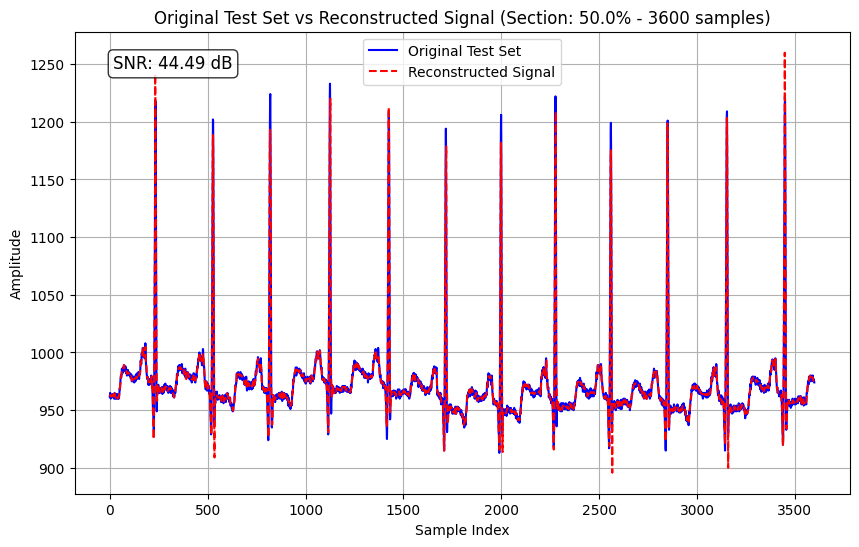

In [287]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data0 = scipy.io.loadmat('100m.mat')  # Ensure the file exists in the current directory

# Extract the ECG data
signal = data0['val'][0]  # MLII ECG data

# Define the portion of the signal you want to use (from 10 to 100 minutes)
signal = signal[360*10:360*100]  # Taking a portion of the signal for testing

# Measurement parameters
BLOCK_LEN = 16
CR = 4
matrix_type = 'DBBD'  # Using the 'DBBD' matrix type for the measurement matrix

# Instantiate the compressedSensing class with the signal and measurement parameters
cs = compressedSensing(signal, BLOCK_LEN, CR, matrix_type)

# Divide the signal into a training set and a test set
# Here, for example, we use 5% of the signal for training
cs.divide_signal(training_percentage=0.05)

# Compress the test set (note that compression happens on the test set only)
cs.compress_test_set()

# Generate the dictionary
cs.generate_dictionary(dictionary_type='dct')

# SL0 parameters for recovery
sl0_params = {
    'sigma_min': 1e-4,
    'sigma_decrease_factor': 0.5,
    'mu_0': 2,
    'L': 3
}

# Recover the original signal using the SL0 algorithm with the provided parameters
cs.recover_signal(**sl0_params)

# Plot the reconstructed signal against the original signal, starting from 50% through the signal
# and plot 360*10 samples (equivalent to 10 minutes of data)
cs.plot_reconstructed_vs_original(start_pct=0.5, num_samples=360*10)
